In [1]:
from IPython.display import clear_output

!wget -O event_log.xes https://www.dropbox.com/scl/fi/0w6j35w8pdea0sq157h18/Sepsis-Cases-Event-Log.xes?rlkey=umh5l1bt3v02ftchmb786m0jw&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pm4py.read_xes('event_log.xes')

log_format = {'case:concept:name': 'case:concept:name',
              'concept:name': 'concept:name',
              'time:timestamp': 'time:timestamp',
              'start_timestamp': '',
              'org:resource': 'org:group',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 1050
Variant count: 846
Event count: 15214
Activity count: 16


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 17.480239 seconds.


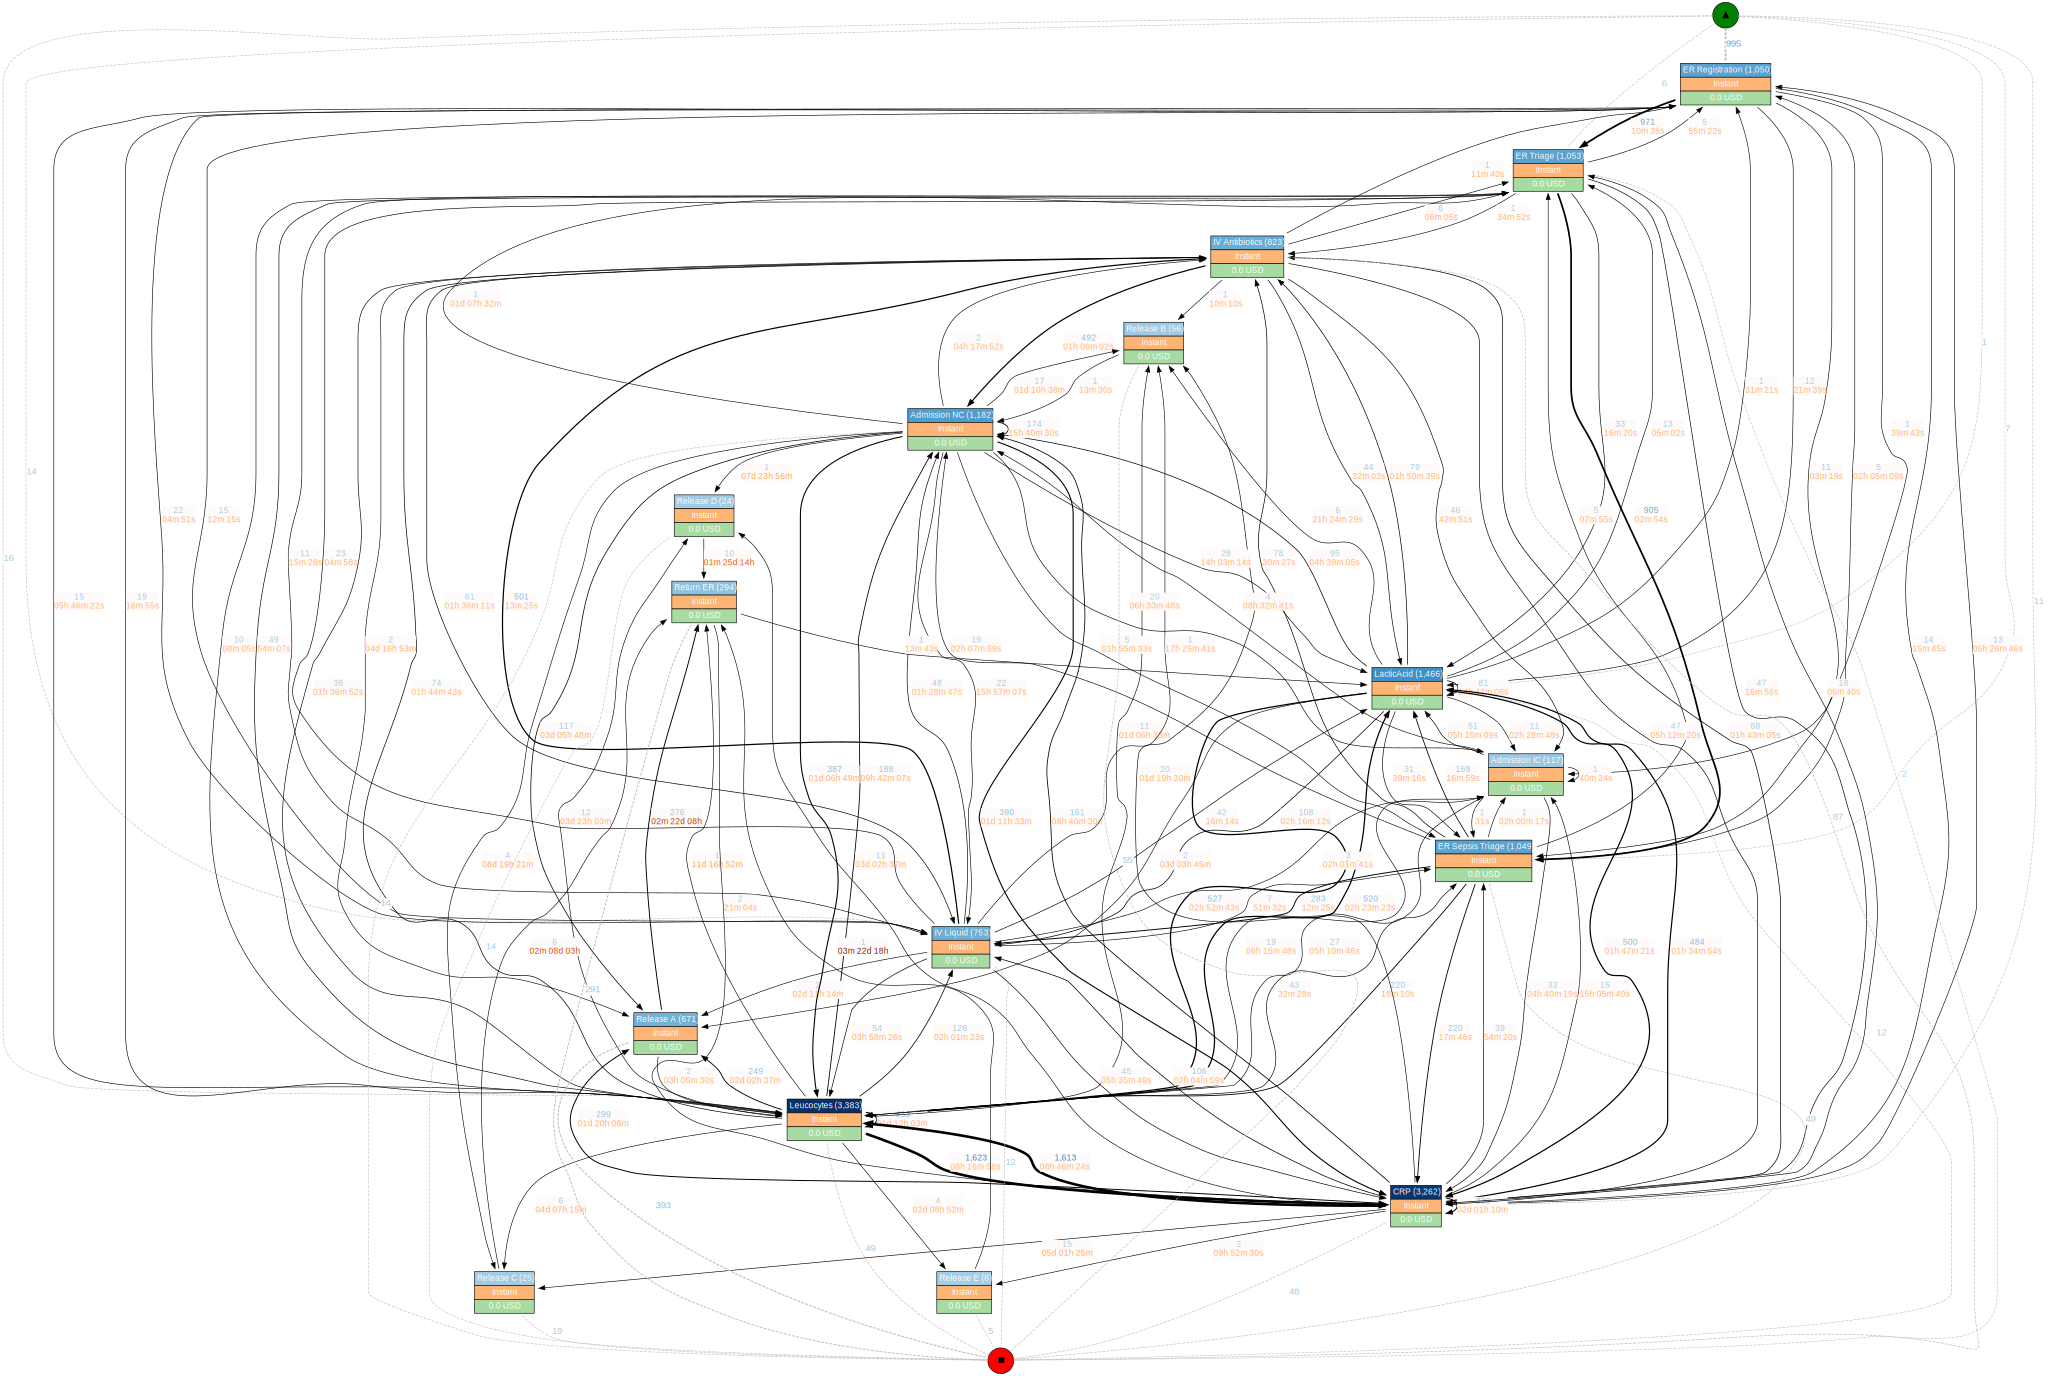

MP-DFG visualization time: 0.786105 seconds.


In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 1050/1050 [00:04<00:00, 233.51it/s]


Calculating log metrics: 


100%|██████████| 1050/1050 [00:04<00:00, 237.24it/s]


Building Tree Cases:


100%|██████████| 1050/1050 [00:09<00:00, 106.67it/s]


Building Tree Graph:


100%|██████████| 1050/1050 [00:00<00:00, 1111.37it/s]


MD-DRT discovery time: 19.843999 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 17.480239 seconds.
MP-DFG visualization time: 0.786105 seconds.
MD-DRT discovery time: 19.843999 seconds.
MD-DRT visualization time: 58.491642 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# The activities of the original log have different release activities that do not provide sufficient additional information
# To reduce the number of activities, all release activities are renamed to a single one
processed_log['concept:name'] = processed_log['concept:name'].apply(lambda x : 'Release' if 'Release' in x else x)

print("Activity count before: " + str(len(set(event_log['concept:name']))))
print("Activity count after: " + str(len(set(processed_log['concept:name']))))

Activity count before: 16
Activity count after: 12


In [13]:
# The original log contains several cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that start with 'ER Registration' and that end with 'Release' or 'Return ER' will be considered
processed_log = pm4py.filter_start_activities(processed_log, ['ER Registration'])
processed_log = pm4py.filter_end_activities(processed_log, ['Release', 'Return ER'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 1050
Case count after: 734


In [14]:
# Some activities are associated to measurements that are recurrently performed over patients (e.g., CRP, Leucocytes)
# These activities are removed, as their inclusion increases the variant count considerably
processed_log = pm4py.filter_event_attribute_values(processed_log, 'concept:name', ['CRP', 'LacticAcid', 'Leucocytes'], level = 'event', retain = False)

print("Variant count before: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Variant count after: " + str(len(pm4py.stats.get_variants(processed_log.copy()))))

Variant count before: 846
Variant count after: 98


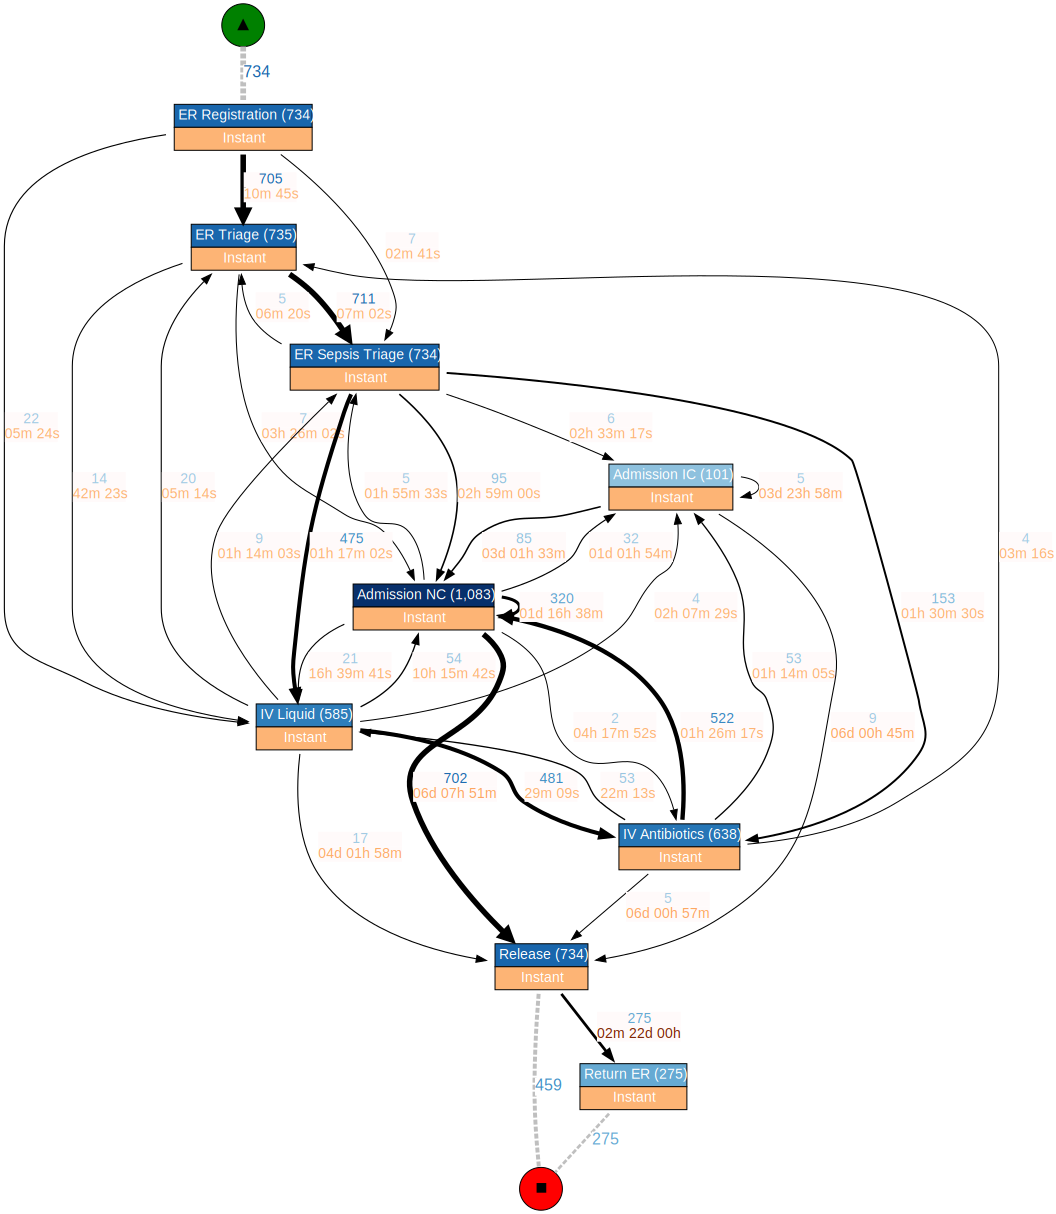

In [15]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

# The frequency of many paths is not high, so only the most common ones are considered
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(75, dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_processed_log_100_75', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_100_75.svg'))

Calculating log mandatory activities: 


100%|██████████| 714/714 [00:01<00:00, 509.72it/s]


Calculating log metrics: 


100%|██████████| 714/714 [00:02<00:00, 338.51it/s]


Building Tree Cases:


100%|██████████| 714/714 [00:04<00:00, 158.48it/s]


Building Tree Graph:


100%|██████████| 714/714 [00:00<00:00, 8212.94it/s]


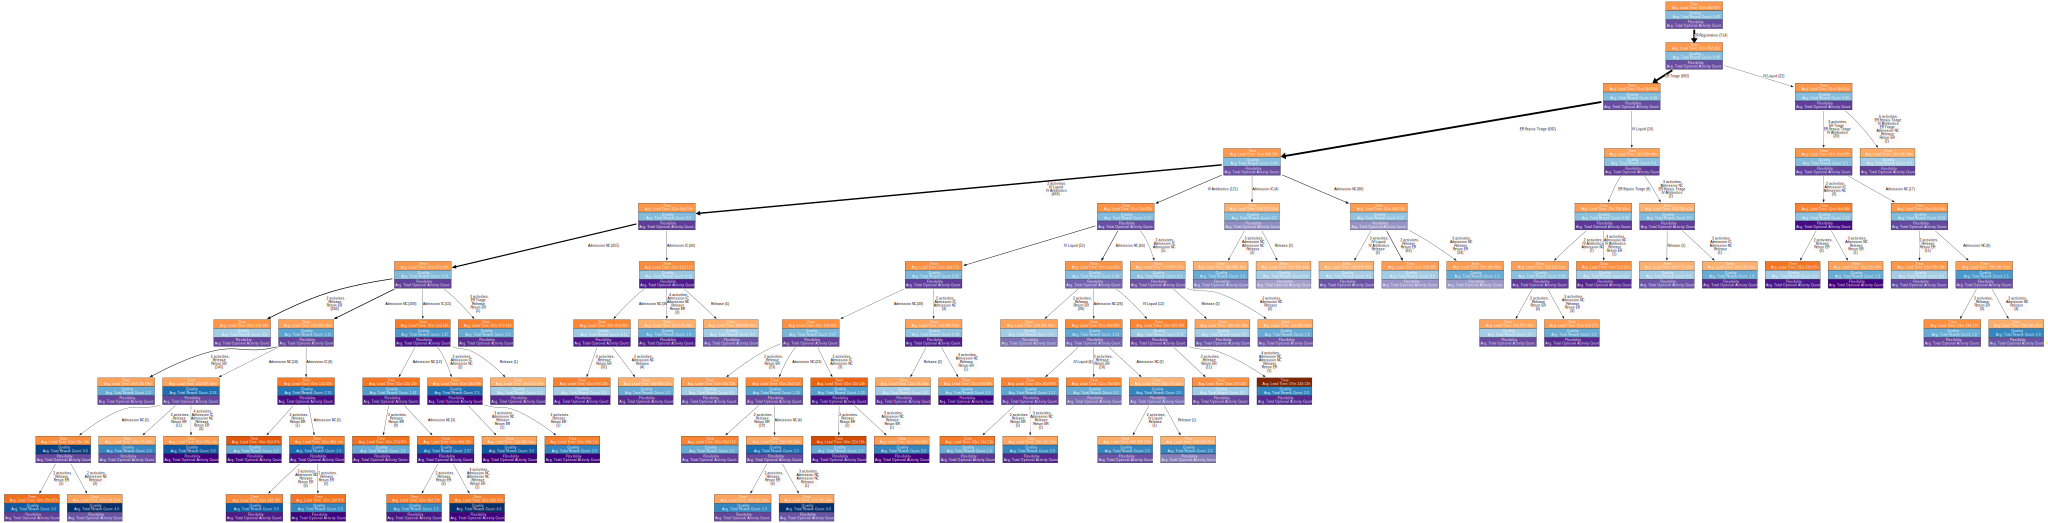

In [16]:
# Since some variants of the process rarely occur (i.e., less than 9 times), only the 80% most common variants are considered
pruned_log = mpvis.preprocessing.prune_log_based_on_top_variants(processed_log.copy(), k = 78)

# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(pruned_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_autogroup_80_variants', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_autogroup_80_variants.svg'))